In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import PIL
from IPython.display import Image, display
from PIL import ImageOps
import random
import re

In [2]:
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
# !tar -xf images.tar.gz
# !tar -xf annotations.tar.gz

In [3]:
def bgr_to_rgb(img):
    b,g,r = cv2.split(img)
    return cv2.merge([r,g,b])

In [4]:
def get_label(file: str, labels: dict):
    match = re.search('[a-z]+', file).group(0)
    return labels[match]

In [5]:
def load_all_imgs(path, img_size, mode):
    imgs = []
    files = os.listdir(path)
    files.sort()
    print(f'\n{path} found {len(files)} img to load')
    for index, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = cv2.imread(img_path, mode)
        
        if mode == 0:
            img = np.expand_dims(img, 2)
        
        if mode == 1:
            img = bgr_to_rgb(img)
        img = cv2.resize(img, img_size)
        img = img / 255.
        imgs.append(img)
        if index % 100 == 0:
            print(f'\n[{index}]:', end='')
        else:
            print("|", end='')
    return np.array(imgs)

In [6]:
img_size = (128, 128)
input_dir = "../dataset/healthy_jpg/"
target_dir = "../dataset/annotation/healthy_jpg/"
num_classes = 1
batch_size = 2
epochs = 30

In [7]:
# Load images
trainImgs = load_all_imgs(input_dir,img_size, 1)
validImgs = load_all_imgs(target_dir,img_size, 0)


../dataset/healthy_jpg/ found 30 img to load

[0]:|||||||||||||||||||||||||||||
../dataset/annotation/healthy_jpg/ found 30 img to load

[0]:|||||||||||||||||||||||||||||

In [8]:
img_to_test = int(len(trainImgs) * 0.8)
x_train = trainImgs[0:img_to_test]
y_train = validImgs[0:img_to_test]
x_val = trainImgs[img_to_test:]
y_val = validImgs[img_to_test:]
validation_data = (x_val, y_val)
print("ImgToTest:",img_to_test)
print("Validation_data_size:", len(validation_data[0]))

ImgToTest: 24
Validation_data_size: 6


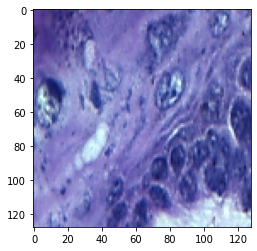

In [9]:
plt.imshow(trainImgs[0])

In [10]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [11]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [12]:
# Build model
model = get_model(img_size, num_classes)
model.summary()

2021-10-07 23:20:38.077776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 23:20:38.081703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 23:20:38.082059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-07 23:20:38.082951: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
class DisplasiaDataSet(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = cv2.imread(path, 1)
            img = bgr_to_rgb(img)
            img = cv2.resize(img, self.img_size)
            img = img / 255.
#             img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = cv2.imread(path, 0)
            img = cv2.resize(img, img_size)
            img = img / 255.
            img = np.expand_dims(img, 2)
#             img = img / 255.
            y[j] = img
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
#             y[j] -= 1
        return x, y

In [14]:
threshold = 0.5
metric = keras.metrics.MeanIoU(num_classes=2)
def mean_iou_threshold(y_true, y_pred):
    y_pred = y_pred.numpy()
    y_pred[y_pred > threshold]= 1
    y_pred[y_pred <= threshold] = 0
    metric.reset_states()
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

In [15]:
model.compile(run_eagerly=True,optimizer="adam", loss="binary_crossentropy", metrics=mean_iou_threshold)

In [17]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
model.fit(x_train, y_train, epochs=epochs, validation_data=validation_data, callbacks=callbacks)

2021-10-07 23:21:25.695451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-10-07 23:21:25.997240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


1/1 [==============================] - 2s 2s/step - loss: 1.4706 - mean_iou_threshold: 0.3315 - val_loss: 0.6283 - val_mean_iou_threshold: 0.3816


/home/neto/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/15
1/1 [==============================] - 0s 254ms/step - loss: 2.8029 - mean_iou_threshold: 0.4471 - val_loss: 0.6239 - val_mean_iou_threshold: 0.3816
Epoch 3/15
1/1 [==============================] - 0s 246ms/step - loss: 2.1980 - mean_iou_threshold: 0.4804 - val_loss: 0.6281 - val_mean_iou_threshold: 0.3816
Epoch 4/15
1/1 [==============================] - 0s 251ms/step - loss: 1.2462 - mean_iou_threshold: 0.4842 - val_loss: 0.6229 - val_mean_iou_threshold: 0.3816
Epoch 5/15
1/1 [==============================] - 0s 240ms/step - loss: 0.7949 - mean_iou_threshold: 0.4779 - val_loss: 0.6292 - val_mean_iou_threshold: 0.3816
Epoch 6/15
1/1 [==============================] - 0s 251ms/step - loss: 0.7857 - mean_iou_threshold: 0.4896 - val_loss: 0.6360 - val_mean_iou_threshold: 0.3816
Epoch 7/15
1/1 [==============================] - 0s 248ms/step - loss: 0.6170 - mean_iou_threshold: 0.4819 - val_loss: 0.6405 - val_mean_iou_threshold: 0.3816
Epoch 8/15
1/1 [========================

In [20]:
val_preds = model.predict(np.array([trainImgs[0]]))

In [21]:
val_preds.shape

(1, 128, 128, 1)

In [32]:
def display_mask(img):
    """Quick utility to display a model's prediction."""
    predict_img = img
    predict_img[predict_img > threshold] = 1
    predict_img[predict_img <= threshold] = 0

    predict_img_original_size = cv2.resize(
        predict_img,
        (128, 128),
        interpolation=cv2.INTER_NEAREST
    )
    predict_img_original_size = predict_img_original_size * 255.0
    plt.imshow(predict_img_original_size, cmap=plt.cm.binary)

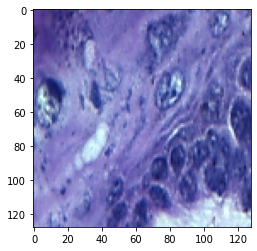

In [29]:
# Display input image
plt.imshow(trainImgs[0])

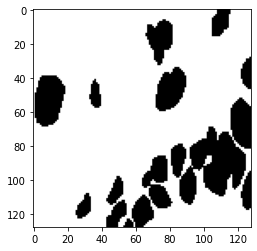

In [33]:
# Display ground-truth target mask
display_mask(validImgs[0])

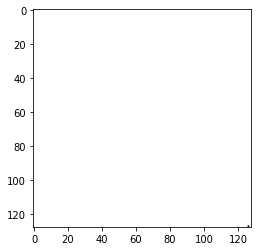

In [34]:
display_mask(val_preds[0])

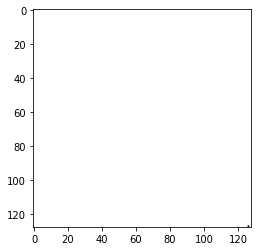

In [38]:
plt.imshow(val_preds[0], cmap=plt.cm.binary)